**# Task 3: Energy Consumption Time Series Forecasting:**
- **Objective:**
  - Forecast short-term household energy usage using historical time-based patterns.
- **Dataset:**
  - Household Power Consumption Dataset
- **Instructions:**
  - Parse and resample the time series data
  - Engineer time-based features (e.g., hour of day, weekday/weekend)
  - Compare performance of ARIMA, Prophet, and XGBoost models
  - Plot actual vs. forecasted energy usage for visualization
- **Skills Gained:**
  - Time series forecasting
  - Feature engineering
  - Model comparison and evaluation (MAE, RMSE)
  - Temporal data visualization

# **Import Libraries:**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor


# **Load Data:**

In [72]:
df = pd.read_csv('/content/household_power_consumption - Copy.csv.zip')
df.head(100)

,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
1,00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2,00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
3,00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
4,00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,01:35:00,2.444,0.000,239.95,10.2,0.0,0.0,0.0
96,01:36:00,2.444,0.000,239.91,10.2,0.0,0.0,0.0
97,01:37:00,2.462,0.000,240.89,10.2,0.0,0.0,0.0
98,01:38:00,2.510,0.052,240.01,10.4,0.0,0.0,0.0


# **Exploratory Data Analysis (EDA):**
- **global_active_power:** The household global minute-averaged active power consumed. Active power is the actual power used
- **global_reactive_power:** The household global minute-averaged reactive power consumed. Reactive power is the unused power
- **voltage:** The minute-averaged voltage level
- **Global_intensity:** The household global minute-averaged current intensity
- **Sub_metering_1**: Active energy consumed by sub-metering No. 1, which corresponds to the kitchen
- **Sub_metering_2:** Active energy consumed by sub-metering No. 2, which corresponds to the laundry room
- **Sub_metering_3**: Active energy consumed by sub-metering No. 3, which corresponds to the electric water-heater and air-conditioner.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   260640 non-null  object 
 1   global_active_power    256869 non-null  float64
 2   global_reactive_power  256869 non-null  float64
 3   voltage                256869 non-null  float64
 4   global_intensity       256869 non-null  float64
 5   sub_metering_1         256869 non-null  float64
 6   sub_metering_2         256869 non-null  float64
 7   sub_metering_3         256869 non-null  float64
dtypes: float64(7), object(1)
memory usage: 15.9+ MB


In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,256869.0,1.164937,1.181832,0.082,0.296,0.564,1.606,10.670
global_reactive_power,256869.0,0.123729,0.111872,0.000,0.000,0.104,0.194,1.148
voltage,256869.0,239.208981,3.592793,223.490,236.650,239.610,241.810,250.890
global_intensity,256869.0,4.974755,4.999493,0.400,1.400,2.600,6.800,46.400
sub_metering_1,256869.0,1.332481,6.704970,0.000,0.000,0.000,0.000,78.000
sub_metering_2,256869.0,1.670610,6.631361,0.000,0.000,0.000,1.000,78.000
sub_metering_3,256869.0,5.831825,8.186709,0.000,0.000,0.000,17.000,20.000


In [75]:
df.shape

(260640, 8)

# **Data Cleaning & Datetime Parsing:**

In [76]:
df["global_active_power"] = pd.to_numeric(
    df["global_active_power"], errors="coerce"
)

df.dropna(inplace=True)

## **Create Datetime Column:**

In [77]:
df["Datetime"] = pd.date_range(
    start="2024-01-01 00:00:00",
    periods=len(df),
    freq="min"   # Minute frequency
)

df.set_index("Datetime", inplace=True)


In [78]:
df.head()

,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
Datetime,,,,,,,,
2024-01-01 00:00:00,00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
2024-01-01 00:01:00,00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2024-01-01 00:02:00,00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
2024-01-01 00:03:00,00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
2024-01-01 00:04:00,00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


- “The dataset lacked a date column, but readings were at fixed intervals, so I created a synthetic datetime index.”
- ✅ This does NOT change the pattern, only gives time context.

## **Visualize Raw Houehold Consumption(Minuts):**

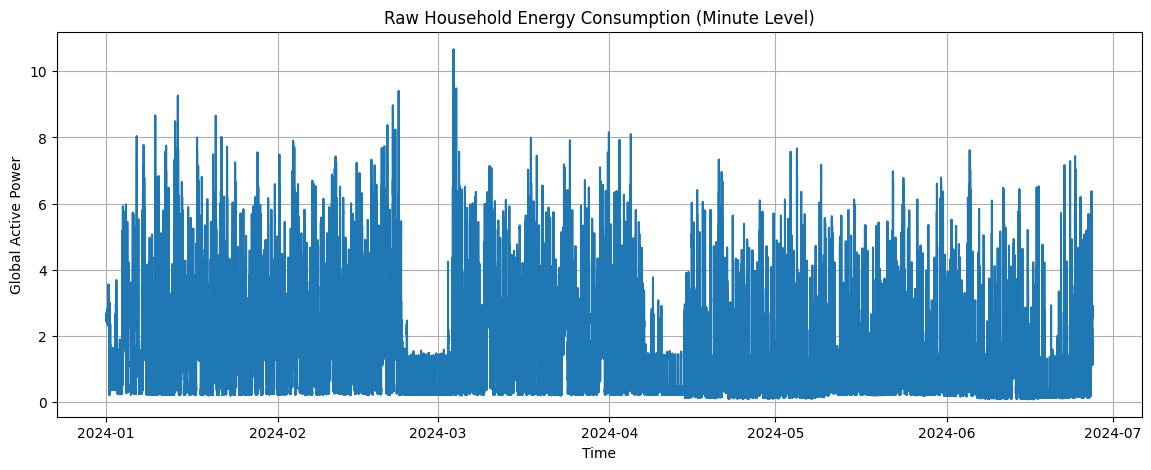

In [79]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df["global_active_power"])
plt.title("Raw Household Energy Consumption (Minute Level)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.grid(True)
plt.show()

- Energy usage fluctuates rapidly, showing minute-level changes in household activity.
-  Sharp peaks suggest intermittent use of high-power appliances.

## **Resample Data (Hourly):**
✅ Reduces noise

✅ Improves forecasting stability

In [80]:
df_hourly = df["global_active_power"].resample("h").mean()
df_hourly.head()

,global_active_power
Datetime,
2024-01-01 00:00:00,2.550633
2024-01-01 01:00:00,2.523400
2024-01-01 02:00:00,2.582333
2024-01-01 03:00:00,2.541667
2024-01-01 04:00:00,2.475733


## **Visualize Raw Energy Consumption(Hourly):**
Identify trends, spikes, noise

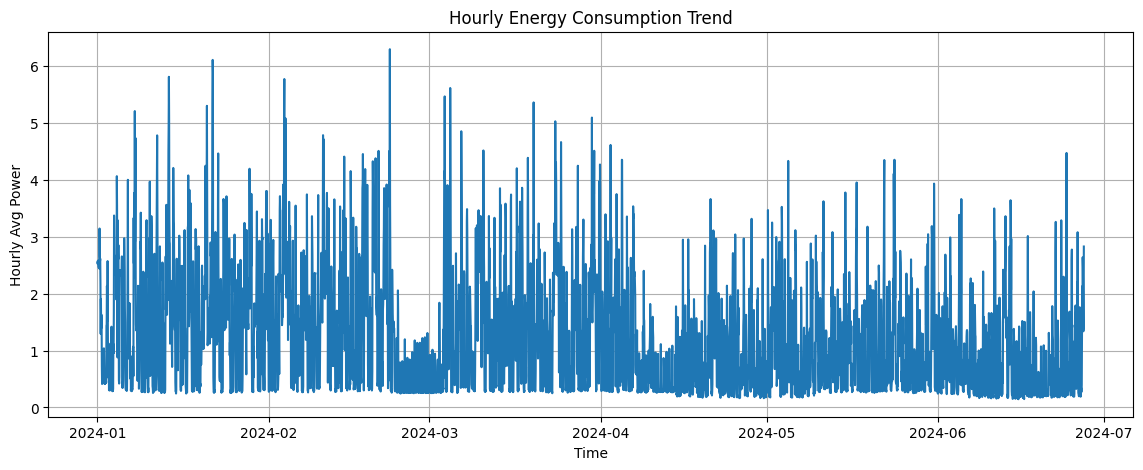

In [81]:
plt.figure(figsize=(14,5))
plt.plot(df_hourly.index, df_hourly)
plt.title("Hourly Energy Consumption Trend")
plt.xlabel("Time")
plt.ylabel("Hourly Avg Power")
plt.grid(True)
plt.show()

- Compared to minute-level data, hourly averaging reduces noise and reveals clearer consumption patterns.
- Power usage still varies significantly across hours, indicating dynamic household behavior throughout the day.
- he hourly resolution makes it easier to detect trends, anomalies, and peak usage periods.

## **Visualize Hourly Energy Usage of Day:**

<Axes: title={'center': 'Average Energy Usage by Hour of Day'}, xlabel='Datetime'>

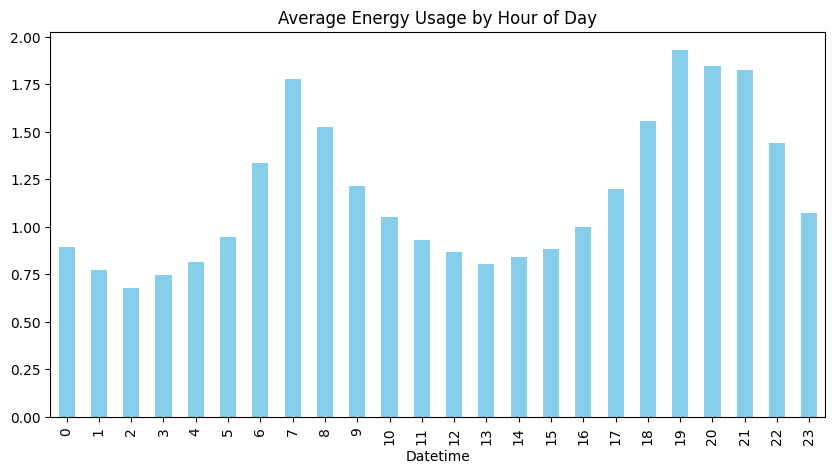

In [82]:
df.groupby(df.index.hour)['global_active_power'].mean().plot(kind='bar',
    figsize=(10,5), color='skyblue', title='Average Energy Usage by Hour of Day')

- Energy consumption is highest during specific hours, typically in the morning and evening, reflecting household routines like cooking, heating, or appliance use.

## **Feature Engineering (TIME-BASED):**
- **Rename Column to 'power'**
  - Simplifies reference for modeling.
- **Extract Hour of Day (hour)**
  - Captures daily patterns (e.g., peak usage at 7 PM).
- **Extract Day of Week (dayofweek)**
  - Values range from 0 (Monday) to 6 (Sunday), useful for weekly trends.
- **Create Weekend Flag (is_weekend)**
  - Binary feature: 1 for Saturday/Sunday, 0 otherwise. Helps model behavioral differences.
- **Add Lag Features (lag_1, lag_24)**
  - lag_1: Power usage 1 hour ago
  - lag_24: Power usage 24 hours ago
  - These help capture temporal dependencies for forecasting.
- **Drop Missing Values**
  - Ensures clean data after lagging (first few rows will be NaN).
- **Preview with head()**
  - Shows the enriched dataset with new features ready for modeling.


In [83]:
df_feat = df_hourly.to_frame(name="power")

df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)

# Lag features (VERY IMPORTANT for ML)
df_feat["lag_1"] = df_feat["power"].shift(1)
df_feat["lag_24"] = df_feat["power"].shift(24)

df_feat.dropna(inplace=True)
df_feat.head()

,power,hour,dayofweek,is_weekend,lag_1,lag_24
Datetime,,,,,,
2024-01-02 00:00:00,0.446433,0,1,0,0.449967,2.550633
2024-01-02 01:00:00,0.436733,1,1,0,0.446433,2.523400
2024-01-02 02:00:00,0.431567,2,1,0,0.436733,2.582333
2024-01-02 03:00:00,0.464167,3,1,0,0.431567,2.541667
2024-01-02 04:00:00,1.039967,4,1,0,0.464167,2.475733


- These features improve model accuracy by capturing time-based behavior, seasonality, and autocorrelation.


## **Comparison Plot Weekday vs Weekend Energy Usage:**

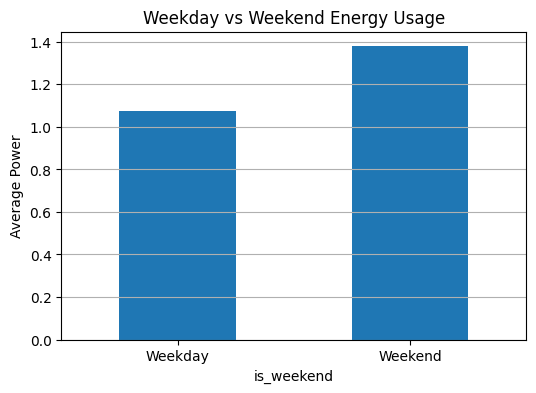

In [84]:
weekend_avg = df_feat.groupby("is_weekend")["power"].mean()

plt.figure(figsize=(6,4))
weekend_avg.plot(kind="bar")
plt.xticks([0,1], ["Weekday", "Weekend"], rotation=0)
plt.title("Weekday vs Weekend Energy Usage")
plt.ylabel("Average Power")
plt.grid(axis="y")
plt.show()

- **Higher Weekend Consumption:**
  - The average power usage is noticeably higher on weekends, suggesting increased household activity—likely due to more time spent at home.
- **Lower Weekday Usage:**
  - Weekdays show reduced energy consumption, possibly because occupants are away for work or school during the day.


## **Train-Test Split:**

In [85]:
train_size = int(len(df_feat) * 0.8)

train = df_feat.iloc[:train_size]
test = df_feat.iloc[train_size:]

# **Model 1: ARIMA:**

In [86]:
# ARIMA model with parameters
arima_model = ARIMA(train["power"], order=(2,1,2))
# Model fit
arima_fit = arima_model.fit()

# Predicts future values equal to the length of the test set
arima_forecast = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


# **Model 2: Prophet:**

In [87]:
# Prepare Data for Prophet Model
prophet_train = train.reset_index()[["Datetime", "power"]]
# ds: datetime
# y: target variable (power consumption)
prophet_train.columns = ["ds", "y"]
# Model fit
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Forecast Future Values
future = prophet_model.make_future_dataframe(periods=len(test), freq="h")

# Define forecast before using it
forecast = prophet_model.predict(future)

# Extracts predicted values (yhat) for the test period:
prophet_forecast = forecast["yhat"].iloc[-len(test):].values

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# **MODEL 3: XGBoost:**

In [88]:
X_train = train.drop("power", axis=1) #  keeps all features except the target
y_train = train["power"]              # selects the target variable (power consumption)

# Same logic applies to X_test and y_test.
X_test = test.drop("power", axis=1)
y_test = test["power"]

# Model Initialization
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Model fit
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)


# **Evaluation (MAE & RMSE):**

In [89]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred) # MAE between predicted and actual values.
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # RMSE
    print(f"{name} → MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Evaluates Three Models
evaluate(test["power"], arima_forecast, "ARIMA")
evaluate(test["power"], prophet_forecast, "Prophet")
evaluate(test["power"], xgb_forecast, "XGBoost")

ARIMA → MAE: 0.654, RMSE: 0.798
Prophet → MAE: 0.727, RMSE: 0.941
XGBoost → MAE: 0.446, RMSE: 0.638


- **ARIMA**: Decent performance, but room for improvement.
- **Prophet:** Least accurate among the three
- **XGBoost:** Best performance, lowest error values

# **Visualization (Actual vs Forecast):**

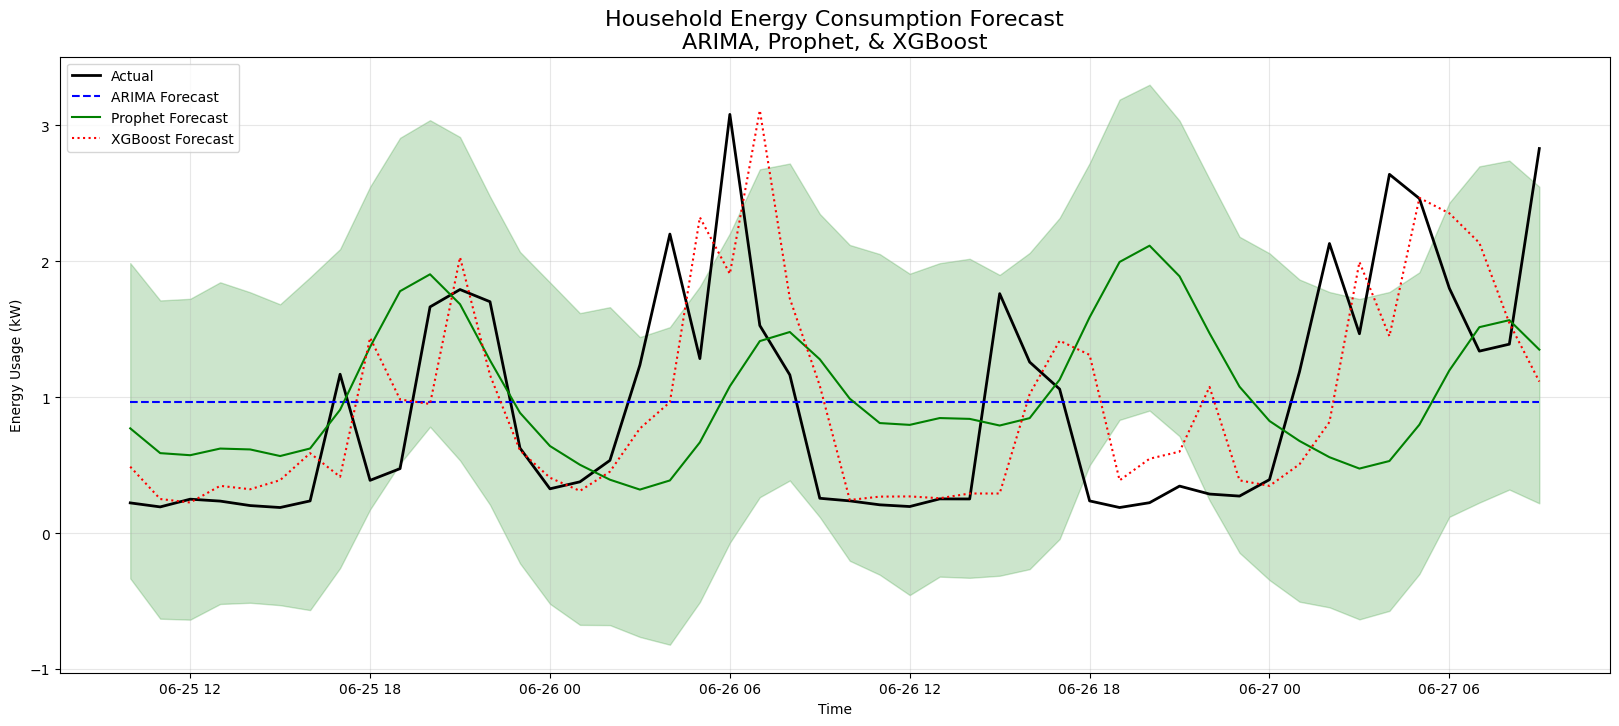

In [90]:
plt.figure(figsize=(20,8))

# Plot actuals for the last 48 hours of the test set
plt.plot(test.index[-48:], test['power'][-48:],
         label='Actual', color='black', linewidth=2)

# Plot ARIMA forecast for the last 48 hours of the test set
plt.plot(test.index[-48:], arima_forecast[-48:],
         label='ARIMA Forecast', color='blue', linestyle='--')

# Plot Prophet forecast for the last 48 hours of the test set
# Using the 'forecast' DataFrame directly for column access
plt.plot(forecast['ds'].iloc[-len(test):][-48:], forecast['yhat'].iloc[-len(test):][-48:],
         label='Prophet Forecast', color='green', linestyle='-')

plt.fill_between(forecast['ds'].iloc[-len(test):][-48:],
                 forecast['yhat_lower'].iloc[-len(test):][-48:],
                 forecast['yhat_upper'].iloc[-len(test):][-48:],
                 color='green', alpha=0.2)

# Plot XGBoost forecast for the last 48 hours of the test set
plt.plot(test.index[-48:], xgb_forecast[-48:],
         label='XGBoost Forecast', color='red', linestyle=':')

plt.title("Household Energy Consumption Forecast\nARIMA, Prophet, & XGBoost", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Energy Usage (kW)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- **ARIMA Forecast:** Good at capturing short-term trends but less responsive to sudden fluctuations.
- **Prophet Forecast:** Trends to smooth out variations, which may miss sharp peaks or dips.
- **XGBoost Forecast:** Closely follows the actual curve, especially during peak and dip periods


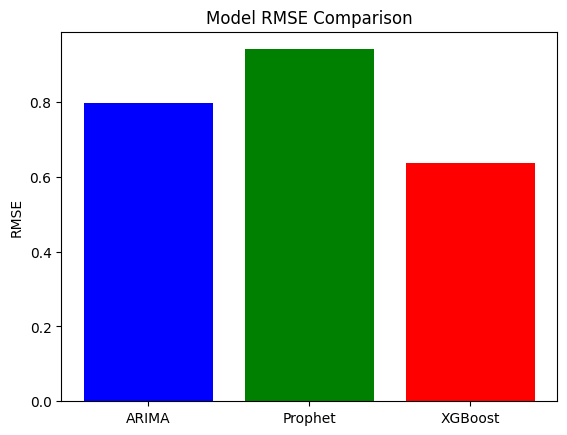

In [91]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# A dictionary errors holds RMSE values for ARIMA, Prophet, XGBoost
errors = {
    'ARIMA': calculate_rmse(y_test, arima_forecast),
    'Prophet': calculate_rmse(y_test, prophet_forecast), # prophet_forecast is already the yhat array for the test set
    'XGBoost': calculate_rmse(y_test, xgb_forecast)
}

plt.bar(errors.keys(), errors.values(), color=['blue','green','red'])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

- **XGBoost:** Has the lowest RMSE, indicating the most accurate predictions
- **ARIMA:** Performs moderately well
- **Prophet:** Shows the highest RMSE

# **Final Conclusion:**

- **XGBoost** performed the best among all models, achieving the lowest MAE (0.446) and lowest RMSE (0.638).
- This indicates that XGBoost predictions are closest to actual energy consumption values with fewer large errors.
- The superior performance of XGBoost is mainly due to:
  - Effective time-based feature engineering (hour, weekday/weekend)
  - Use of lag features, which capture short-term dependencies in energy usage
- For short-term household energy consumption forecasting, XGBoost is the most suitable model, as it provides higher accuracy and better adaptability to complex usage patterns.